In [37]:
import pandas as pd
import numpy  as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import pickle
% matplotlib inline

import folium
from IPython.display import HTML


In [21]:
%run -i 'Data/ZHVI/metro_dictionaries.py' 
# Loads 
#  metroString(dict of 'city': 'City, CA')
#  metroRegionId() dict of 'City, CA': ZillowRegionIdInt
reverse_metroString = dict((v, k) for k, v in metroString.items())

zhvi = pd.read_csv('Data/ZHVI/Metro_Zhvi_AllHomes.csv',index_col=[1]) # Use this for mapping regionName to sizeRank

regionIDtoFIPS = pd.read_csv('Data/ZHVI/CountyCrossWalk_Zillow.csv')
regionIDtoFIPS = regionIDtoFIPS.dropna(how='any')
regionIDtoFIPS['MetroRegionID_Zillow'] = regionIDtoFIPS['MetroRegionID_Zillow'].astype(int)

fipsDetails = pd.read_csv('Data/ZHVI/txt1.csv',encoding = "ISO-8859-1")
fipsDetails = fipsDetails.set_index('FIPS',drop=True)

rmse = pd.read_csv('Data/Results/rmse_36_2_36.csv',index_col=0, converters={'rmse':lambda x:float(x.strip('%'))/100})
rmse = rmse['rmse'] # We just want the Series of RMSE values, indexed by 

In [125]:
zhvi.head()

,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
RegionName,,,,,,,,,,,,,,,,,,,,,
United States,102001,0,99600.0,100000.0,100000.0,99900.0,99800.0,99900.0,100000.0,100400.0,...,189100,190300,191600,193000,194200.0,195100,195900,197100,198300,199200
"New York, NY",394913,1,165700.0,167000.0,167200.0,166700.0,166300.0,166100.0,165400.0,164200.0,...,393200,396500,399100,401600,403600.0,405600,408700,412500,416100,419000
"Los Angeles-Long Beach-Anaheim, CA",753899,2,170600.0,170400.0,170100.0,169900.0,169900.0,169900.0,170000.0,170200.0,...,578300,581300,585400,590300,594300.0,597000,599200,601700,604300,606500
"Chicago, IL",394463,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200600,201600,202600,203700,205100.0,206800,208400,209200,209800,210200
"Dallas-Fort Worth, TX",394514,4,102200.0,102100.0,102100.0,102300.0,102400.0,102600.0,102200.0,99400.0,...,196100,197600,199500,200800,201500.0,202500,204000,205800,207900,209200


In [ ]:
# Want to go from 'City' to lat/lon
# Need to go from 'city' -> 'City, CA' -> MetroRegionID -> FIPS -> LatLon
#                  metroString[city] 

In [133]:
cityLoc = pd.DataFrame()

for city in metroString.keys():
    metro = metroString[city]
    regID = int(metroRegionID[metro])
    FIPS  = regionIDtoFIPS[regionIDtoFIPS['MetroRegionID_Zillow']==regID]['FIPS'].iloc[0]
    cityLoc.loc[city,'lat']  = fipsDetails.loc[FIPS,'latitude']
    cityLoc.loc[city,'lon']  = fipsDetails.loc[FIPS,'longitude']
    cityLoc.loc[city,'sizeRank'] = zhvi.loc[metro,'SizeRank']

print(cityLoc.shape)
cityLoc = cityLoc.join(rmse,how='inner')
print(cityLoc.shape)

(559, 3)
(395, 4)


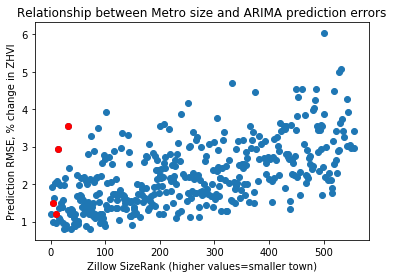

In [147]:
myCities = ['Atlanta','Dallas-FortWorth','Phoenix','LasVegas']

plt.scatter(cityLoc['sizeRank'],cityLoc['rmse']*100)
plt.scatter(cityLoc.loc[myCities,'sizeRank'],cityLoc.loc[myCities,'rmse']*100,color='r')
plt.title('Relationship between Metro size and ARIMA prediction errors')
plt.ylabel('Prediction RMSE, % change in ZHVI')
plt.xlabel('Zillow SizeRank (higher values=smaller town)')

In [148]:
## Plotting setup

import matplotlib.colors as colors
import matplotlib.cm as cm

norm = colors.Normalize(vmin=rmse.min(), vmax=0.04)#rmse.max())
cmap = cm.viridis #plasma
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def rmse2hex(x):
    return colors.rgb2hex( m.to_rgba(x)[0:3])

In [155]:
myMap = folium.Map(location=[37, -100], width=800,height=450,zoom_start=4)
sizeRankCutoff = 200 # SizeRank must be this size or smaller

temp = cityLoc[cityLoc.sizeRank <= sizeRankCutoff]
print("Plotting %s cities"%temp.shape[0])


for city in cityLoc[cityLoc.sizeRank <= sizeRankCutoff].index:
    folium.CircleMarker(location=[cityLoc.loc[city,'lat'],cityLoc.loc[city,'lon']],
                        radius=10,color=None,fill_color=rmse2hex(rmse[city]),
                        popup="%s RMSE= %.3f%%"%(city,rmse[city]*100),
                        fill_opacity=1).add_to(myMap)

myMap

Plotting 167 cities


In [19]:
# ## Convert individual cities' pickled results into one large dictionary containing dataframes for each city (keyed by city name)
# cityResults = {}
# for city in metroString.keys():
#     try:
#         cityResults[city] = pickle.load(open('Data/Results/pickles/'+city+'.pkl','rb'))
#     except FileNotFoundError:
#         pass
# pickle.dump(cityResults,open('Data/Results/pickles/allCityResults.pkl','wb'))